TODO
1) ~~nfsm basic node state~~
2) prune dp
2) ~~nsfm add fd~~
3) prune nfsm

In [15]:
!pip install networkx matplotlib
!pip install prettytable



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [16]:
import networkx as nx
import matplotlib.pyplot as plt
from prettytable import PrettyTable

import networkx as nx
import matplotlib.pyplot as plt

def draw_dfsm_graph(nodes, edges, q0):
    G = nx.DiGraph()

    interesting = []
    drawable_edges = []
    for edge in edges:
        l = []
        counter = 0
        skipline = ''
        for node in nodes[edge.lhs]:
            counter += 1
            if counter == 4:
                skipline = '\n'
                counter = 0
            l.append('(' + ','.join(node.ordering.order) + ')' + skipline)
            skipline= ''
        r = []
        counter = 0
        for node in nodes[edge.rhs]:
            counter += 1
            if counter == 4:
                skipline = '\n'
                counter = 0
            r.append('(' + ','.join(node.ordering.order) + ')' + skipline)
            skipline = ''
        
        if edge.rhs in q0:
            interesting.append(f'{edge.rhs}. ' + ','.join(r))

        if edge.lhs in q0:
            interesting.append(f'{edge.lhs}. ' + ','.join(l))

        edge_label = edge.fd if edge.fd else 'eps'
        drawable_edges.append((f'{edge.lhs}. ' + ','.join(l), f'{edge.rhs}. ' + ','.join(r), edge_label))

    G.add_edges_from([(u, v, {'label': label}) for u, v, label in drawable_edges])

    # Выбор макета (можно экспериментировать с разными макетами)
    pos = nx.spring_layout(G, k = 0.5, seed=1233, iterations=90)
    # pos = nx.circular_layout(G)  # альтернативный макет
    # pos = nx.shell_layout(G)  # ещё один альтернативный макет

    plt.figure(figsize=(24, 10))

    node_colors = []
    for i, n in enumerate(G.nodes()):
        if n in interesting:
            node_colors.append('red')
        else:
            node_colors.append('lightblue')
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors)

    # Отрисовка рёбер
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='gray', arrows=True, arrowsize=20)

    edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=12, label_pos=0.5)

    nx.draw_networkx_labels(G, pos, font_size=10)

    plt.axis('off')  # Отключить оси
    plt.show()



def draw_graph(nodes, edges):
    G = nx.DiGraph()

    produced = []
    interesting = []
    drawable_edges = []
    for edge in edges:
        lhs = '(' + ','.join(nodes[edge.lhs].ordering.order) + ')'
        rhs = '(' + ','.join(nodes[edge.rhs].ordering.order) + ')'

        if nodes[edge.lhs].ordering.type == Ordering.Type.produced:
            lhs += ' P'
        elif nodes[edge.lhs].ordering.type == Ordering.Type.tested:
            lhs += ' T'
        if nodes[edge.rhs].ordering.type == Ordering.Type.produced:
            rhs += ' P'
        elif nodes[edge.rhs].ordering.type == Ordering.Type.tested:
            rhs += ' T'

        if nodes[edge.lhs].type == NFSMNode.Type.interesting:
            interesting.append(lhs)
        if nodes[edge.rhs].type == NFSMNode.Type.interesting:
            interesting.append(rhs)

        drawable_edges.append((lhs, rhs, {'label': edge.fd if edge.fd else 'eps'}))

    G.add_edges_from(drawable_edges)
    pos = nx.spring_layout(G, seed=12, k=1.5, iterations=90)

    plt.figure(figsize=(24, 12))

    for u, v, d in G.edges(data=True):
        rad = 0.1 if G.has_edge(v, u) else 0
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)], connectionstyle=f'arc3,rad={rad}',
            edge_color='gray', arrows=True, arrowsize=10
        )

    node_colors = []
    for i, n in enumerate(G.nodes()):
        if n in interesting:
            node_colors.append('red')
        else:
            node_colors.append('lightblue')

    nx.draw_networkx_nodes(G, pos, node_size=100, node_color=node_colors)
    nx.draw_networkx_labels(G, pos, font_size=16)

    edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=edge_labels,
        font_color='red', font_size=12, label_pos=0.7
    )

    plt.show()



In [17]:
import enum
import networkx as nx
import matplotlib.pyplot as plt


class FD:
    class Type(enum.Enum):
        eps = 0
        equiv = 1
        ordinary = 2

    def __init__(self, activation_nodes: str, required_nodes: str, type=Type.ordinary):
        if len(activation_nodes) == 0 and len(required_nodes) == 0:
            self.type = self.Type.eps
        else:
            self.type = type
            
        self.activation_nodes = activation_nodes
        self.required_nodes = required_nodes

    def __repr__(self) -> str:
        return f'{self.activation_nodes} {"=" if self.type == self.Type.equiv else "->"} {self.required_nodes}'

    def __eq__(self, other):
        if not isinstance(other, FD):
            return NotImplemented
        return (self.activation_nodes == other.activation_nodes and
                self.required_nodes == other.required_nodes and
                self.type == other.type)

    def __hash__(self):
        return hash((self.activation_nodes, self.required_nodes, self.type))

class Ordering:
    class Type(enum.Enum):
        tested = 0
        produced = 1

    def __init__(self, order: list[str], type=''):
        self.order = order
        self.type = type

    def __repr__(self) -> str:
        return '(' + ','.join(self.order) + ')'


In [18]:
from copy import deepcopy
import warnings
from collections import defaultdict
import time


class NFSMNode:
    class Type(enum.Enum):
        artificial = 0
        interesting = 1

    def __init__(self, ordering: Ordering, type: Type) -> None:
        self.ordering = ordering
        self.type = type
        self.outgoing_edges = []

    def __repr__(self) -> str:
        return '{' + f'{self.ordering}, {"A" if self.type == NFSMNode.Type.artificial else "I"}' + '}'

class NFSMEdge:
    def __init__(self, lhs, rhs, fd: set[FD]) -> None:
        self.lhs = lhs
        self.rhs = rhs
        if fd == 'eps':
            self.fd = set()
        else:
            self.fd = fd

    def __repr__(self) -> str:
        return '{' + f'{self.lhs} -> {self.rhs}, {self.fd if self.fd else "eps"}' + '}'

    


class NFSM:
# public methods
    def __init__(self) -> None:
        self.nodes = []
        self.edges = []

    def contains(self):
        raise NotImplemented()
    
    def infer_new_logical_orderings(self, fd_set):
        raise NotImplemented()

    def construct(self, functional_dependencies, produced, tested):
        interesting_orderings = produced + tested
        self.add_init_nodes(interesting_orderings)
        # self.debug_
        # 'init state', True)

        self.prefix_closure()
        # self.debug_print('after prefix closure', True)

        functional_dependencies = self.prune_fds(functional_dependencies)
        self.apply_fd(functional_dependencies)
        self.debug_print('after applying fd', True)

        self.prune_nodes()
        self.debug_print('after pruning nodes', True)


        for idx, edge in enumerate(self.edges):
            self.nodes[edge.lhs].outgoing_edges.append(idx)

        return self.convert_to_dfsm(functional_dependencies, produced)


# private methods
    def add_init_nodes(self, interesting_ordering):
        self.longest_interesting_order = -1
        for ordering in interesting_ordering:
            self.longest_interesting_order = max(self.longest_interesting_order, len(ordering.order))
            self.nodes.append(NFSMNode(ordering, NFSMNode.Type.interesting))

    def prefix_closure(self):
        for ordering in [node.ordering for node in self.nodes]:
            for i in range(1, len(ordering.order)):
                self.add_node(ordering.order[:i])  

        for idx1, ordering1 in enumerate([node.ordering.order for node in self.nodes]):
            for idx2, ordering2 in enumerate([node.ordering.order for node in self.nodes]):
                if ordering1[:len(ordering1) - 1] == ordering2:
                    self.add_edge(idx1, idx2, 'eps')
                    break
                  

    def prune_fds(self, functional_dependencies):
        new_fds = []
        for fd in functional_dependencies:
            used = False
            for idx, node in enumerate(self.nodes):
                if node.type == NFSMNode.Type.interesting and node.ordering.order.count(fd.required_nodes) > 0:
                    used = True
                    break

            if used:
               new_fds.append(fd)

        return new_fds 


    def apply_fd(self, functional_dependencies):
        node_idx = 0

        while node_idx < len(self.nodes):
            node = self.nodes[node_idx]

            for fd in functional_dependencies:
                if fd.activation_nodes in node.ordering.order and fd.required_nodes not in node.ordering.order and len(node.ordering.order) + 1 <= self.longest_interesting_order: # 'b', 
                    pos = node.ordering.order.index(fd.activation_nodes)
                    for i in range(pos + 1, len(node.ordering.order) + 1):
                        new_order = list(node.ordering.order)
                        new_order.insert(i, fd.required_nodes)
                        r_idx = self.add_node(new_order)

                        self.add_edge(node_idx, r_idx, fd)
                        self.add_edge(r_idx, node_idx, 'eps' if node.ordering.order == new_order[:len(new_order) - 1] else fd) 
            
            # ab ; b=c
                if fd.activation_nodes in node.ordering.order and fd.type == FD.Type.equiv:
                    new_order = list(node.ordering.order)
                    pos = node.ordering.order.index(fd.activation_nodes)
                    new_order[pos] = fd.required_nodes

                    r_idx = self.add_node(list(set(new_order)))
                    self.add_edge(node_idx, r_idx, fd)
                    self.add_edge(r_idx, node_idx, fd) 

            node_idx += 1
 
    def prune_nodes(self):
        adjacency_list = {i: [] for i in range(len(self.nodes))}
        for edge in self.edges:
            adjacency_list[edge.rhs].append(edge.lhs)

        interesting_nodes = [idx for idx, node in enumerate(self.nodes) if node.type == NFSMNode.Type.interesting]

        def dfs(node_index, visited):
            stack = [node_index]
            while stack:
                current = stack.pop()
                if not visited[current]:
                    visited[current] = True
                    # Traverse all adjacent nodes
                    for neighbor in adjacency_list.get(current, []):
                        if not visited[neighbor]:
                            stack.append(neighbor)

        reachable = [False] * len(self.nodes)
        for interesting_idx in interesting_nodes:
            visited = [False] * len(self.nodes)

            dfs(interesting_idx, visited)

            for i in range(len(visited)):
                reachable[i] |= visited[i]
        
        self.edges = [edge for idx, edge in enumerate(self.edges) if reachable[edge.lhs] and reachable[edge.rhs]]


    def add_edge(self, l_idx, r_idx, fd):
        for edge in self.edges:
            if l_idx == edge.lhs and r_idx == edge.rhs:
                return edge
            
        self.edges.append(NFSMEdge(l_idx, r_idx, fd))

    def add_node(self, ordering: list[str]) -> int:
        for idx, node in enumerate(self.nodes):
            if node.ordering.order == ordering:
                return idx
            
        node = NFSMNode(ordering=Ordering(ordering), type=NFSMNode.Type.artificial)
        self.nodes.append(node)
        return len(self.nodes) - 1

    def convert_to_dfsm(self, fds, produced):
        dfsm = DFSM(fds)

        for idx, node in enumerate(self.nodes):
            for order in produced:
                if node.ordering == order:
                    nodes = self.with_eps_and_fd_nodes([idx])
                    dfsm.add_q0(DFSMNode(nodes))

        i = 0
        while i < len(dfsm.nodes):
            outgoing_edges = []
            for nfsm_node_idx in dfsm.nodes[i].nfsm_nodes:
                nfsm_node = self.nodes[nfsm_node_idx]
                outgoing_edges.extend( [self.edges[idx] for idx in nfsm_node.outgoing_edges])

            grouped_edges = defaultdict(list)
            for edge in outgoing_edges:
                if edge.fd == set():
                    continue
                grouped_edges[edge.fd].append(edge)

            for fd, edges in grouped_edges.items():
                dfsm_state = self.with_eps_and_fd_nodes([nfsm_node_idx for nfsm_node_idx in dfsm.nodes[i].nfsm_nodes], fd)
                added_idx = dfsm.add_node(DFSMNode(dfsm_state))
                if added_idx != i:
                    dfsm.add_edge(DFSMEdge(i, added_idx, fd))

            i += 1

        draw_dfsm_graph(
            [[self.nodes[node_idx] for node_idx in dfsm_node.nfsm_nodes] for dfsm_node in dfsm.nodes], 
            dfsm.edges,
            dfsm.q0
        )

        dfsm.precompute()
        dfsm.print_precompute()
        print(*dfsm.edges)

        return dfsm
    
    def with_eps_and_fd_nodes(self, nodes_idx, fds = set()):
        eps_nodes = []

        def dfs(node_idx):
            if node_idx in eps_nodes:
                return
            eps_nodes.append(node_idx)
            for edge_idx in self.nodes[node_idx].outgoing_edges:
                edge = self.edges[edge_idx]
                if edge.fd == set() or edge.fd == fds:
                    dfs(edge.rhs)

        for idx in nodes_idx:
            dfs(idx)

        return eps_nodes + nodes_idx

    def debug_print(self, msg = '', draw = False):
        if msg:
            print(msg)
        if draw:
            draw_graph(self.nodes, self.edges)
        print(self)

    def __repr__(self) -> str:
        edges = []
        for e in self.edges:
            l = '(' + ','.join(self.nodes[e.lhs].ordering.order) + ')'
            r = '(' + ','.join(self.nodes[e.rhs].ordering.order) + ')'
            edges.append('{' + f'{l} -> {r}, {e.fd if e.fd else "eps"}' + '}')
        
        str_e = "\n".join(edges)
        return f'Nodes: {self.nodes}\nEdges: \n{str_e}\n'

def create_orderings(orderings : list[str], type: Ordering.Type):
    res = []
    for ordering in orderings:
        res.append(Ordering(list(ordering), type))
    return res


class DFSMEdge:
    def __init__(self, lhs, rhs, fd: set[FD]) -> None:
        self.lhs = lhs
        self.rhs = rhs
        if fd == 'eps':
            self.fd = set()
        else:
            self.fd = fd

    def __repr__(self) -> str:
        return '{' + f'{self.lhs} -> {self.rhs}, {self.fd if self.fd else "eps"}' + '}'

class DFSMNode:
    def __init__(self, nfsm_nodes) -> None:
        self.nfsm_nodes = sorted(set(nfsm_nodes))

    def __repr__(self) -> str:
        return '[' + ','.join(map(str, self.nfsm_nodes)) + ']'
    
    def __eq__(self, other) -> bool:
        if not isinstance(other, DFSMNode):
            return False
        return self.nfsm_nodes == other.nfsm_nodes

    
class DFSM:
    def __init__(self, fds) -> None:
        self.nodes = []
        self.edges = []

        self.fds = fds
        self.q0 = []
        self.matrix = []

    def add_node(self, to_add):
        for i in range(len(self.nodes)):
            if self.nodes[i] == to_add:
                return i
            
        self.nodes.append(to_add)
        return len(self.nodes) - 1
    
    def add_q0(self, to_add):
        idx = self.add_node(to_add)
        self.q0.append(idx)
        return idx
    
    def add_edge(self, edge):
        for e in self.edges:
            if e == edge:
                return
            
        self.edges.append(edge)

    def print_precompute(self):
        table = PrettyTable()
        table.field_names = [""] + list(map(str, self.fds))

        for idx, row in enumerate(self.matrix):
            table.add_row([f'{idx}'] + list(map(str, row)))

        print(table)


    def precompute(self):
        self.matrix = [[0 for fd in range(len(self.fds))] for i in range(len(self.nodes))]

        for edge in self.edges:
            self.matrix[edge.lhs][self.get_fd_idx(edge.fd)] = edge.rhs


    def get_fd_idx(self, fd):
        for fd_idx in range(len(self.fds)):
            if fd == self.fds[fd_idx]:
                return fd_idx


class LogicalOrderings:
    def __init__(self, fds, produced, tested) -> None:
        dfsm = NFSM().construct()

    def contains_orderings() -> bool:
        pass

    def induce(self, fds):
        pass




In [19]:
# produced = create_orderings(['b', 'ab'], Ordering.Type.produced)
# tested = create_orderings(['abc', 'bcl'], Ordering.Type.tested)

# fds = [
#     FD('b', 'c'),
#     FD('b', 'd'),
#     FD('c', 'a'),
# ]

# nfsm = NFSM()
# nfsm.construct(fds, produced, tested)

after applying fd


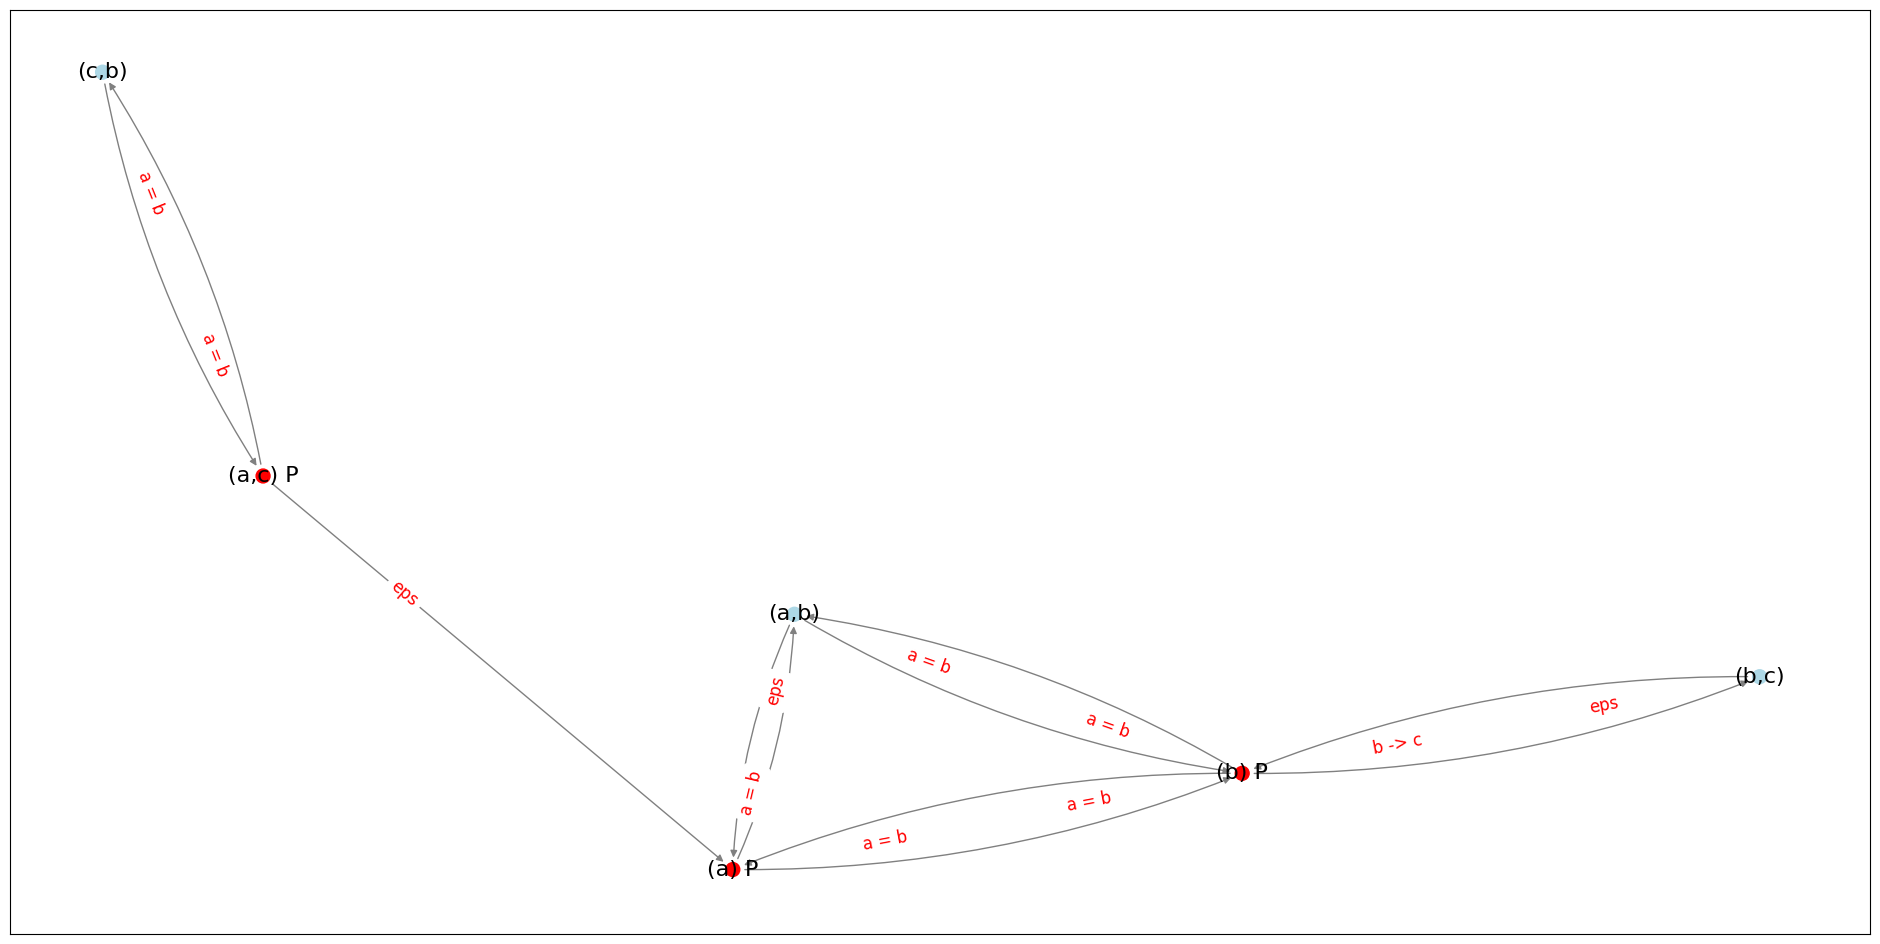

Nodes: [{(a), I}, {(b), I}, {(a,c), I}, {(a,b), A}, {(b,c), A}, {(c,b), A}]
Edges: 
{(a,c) -> (a), eps}
{(a) -> (a,b), a = b}
{(a,b) -> (a), eps}
{(a) -> (b), a = b}
{(b) -> (a), a = b}
{(b) -> (b,c), b -> c}
{(b,c) -> (b), eps}
{(a,c) -> (c,b), a = b}
{(c,b) -> (a,c), a = b}
{(a,b) -> (b), a = b}
{(b) -> (a,b), a = b}

after pruning nodes


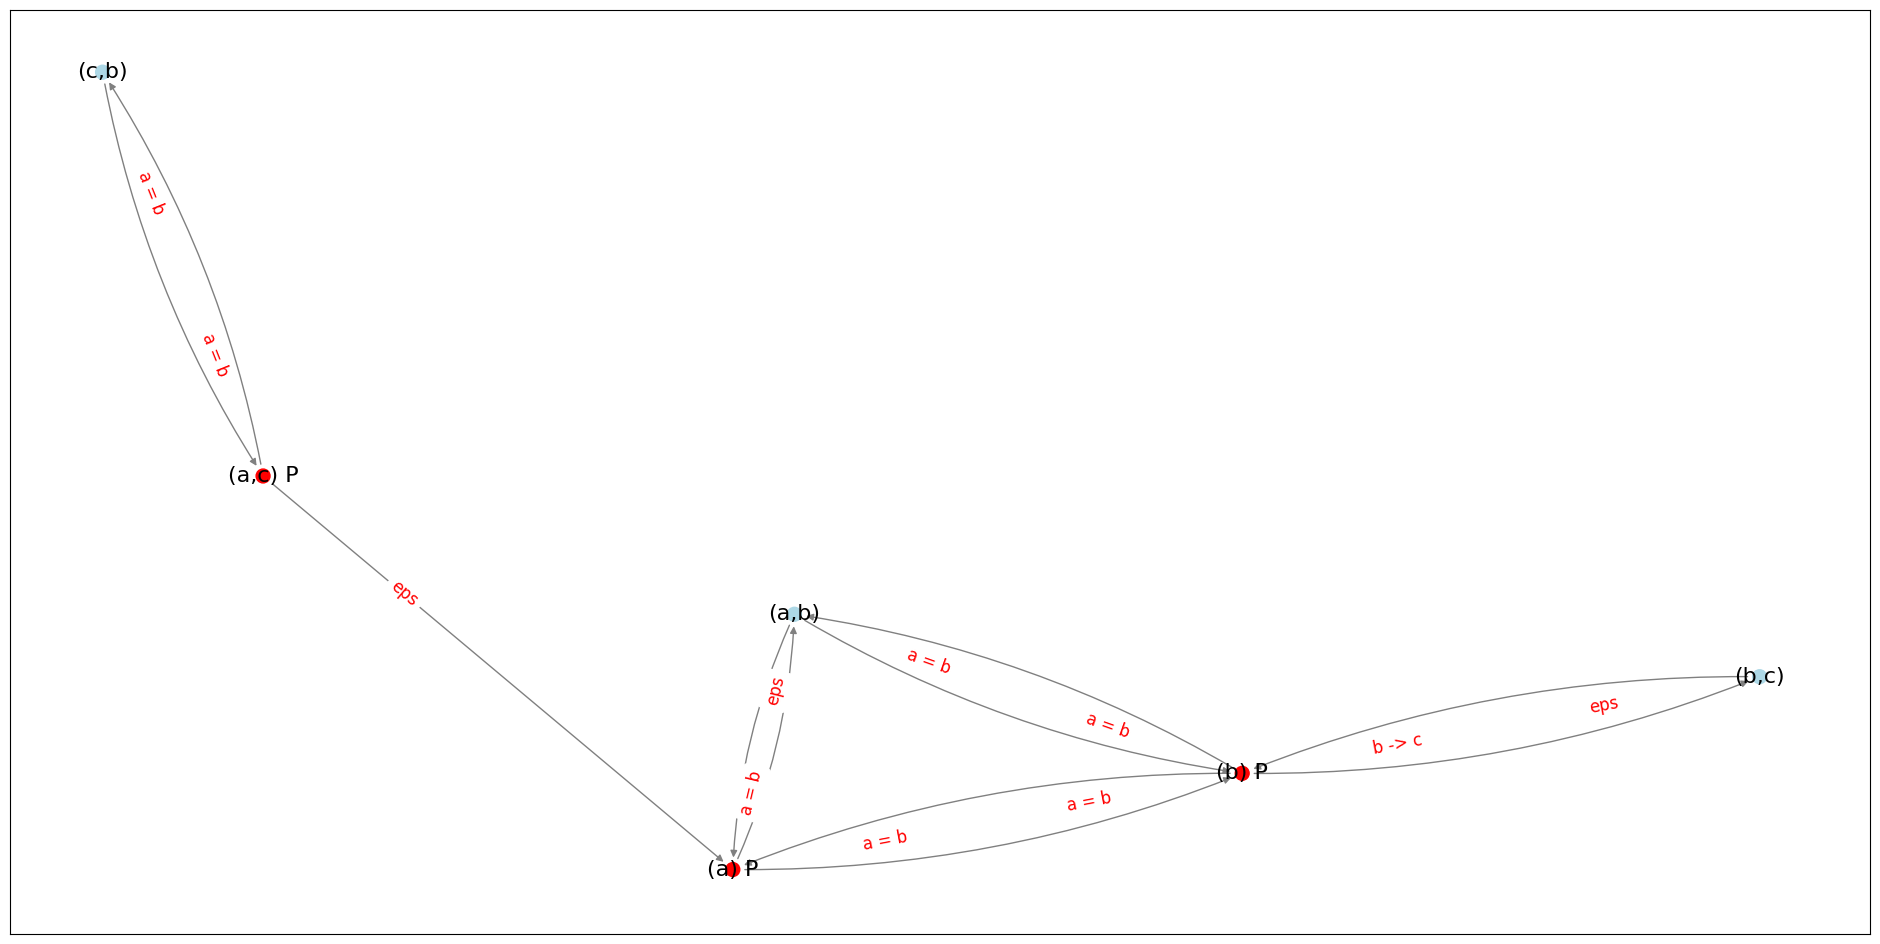

Nodes: [{(a), I}, {(b), I}, {(a,c), I}, {(a,b), A}, {(b,c), A}, {(c,b), A}]
Edges: 
{(a,c) -> (a), eps}
{(a) -> (a,b), a = b}
{(a,b) -> (a), eps}
{(a) -> (b), a = b}
{(b) -> (a), a = b}
{(b) -> (b,c), b -> c}
{(b,c) -> (b), eps}
{(a,c) -> (c,b), a = b}
{(c,b) -> (a,c), a = b}
{(a,b) -> (b), a = b}
{(b) -> (a,b), a = b}



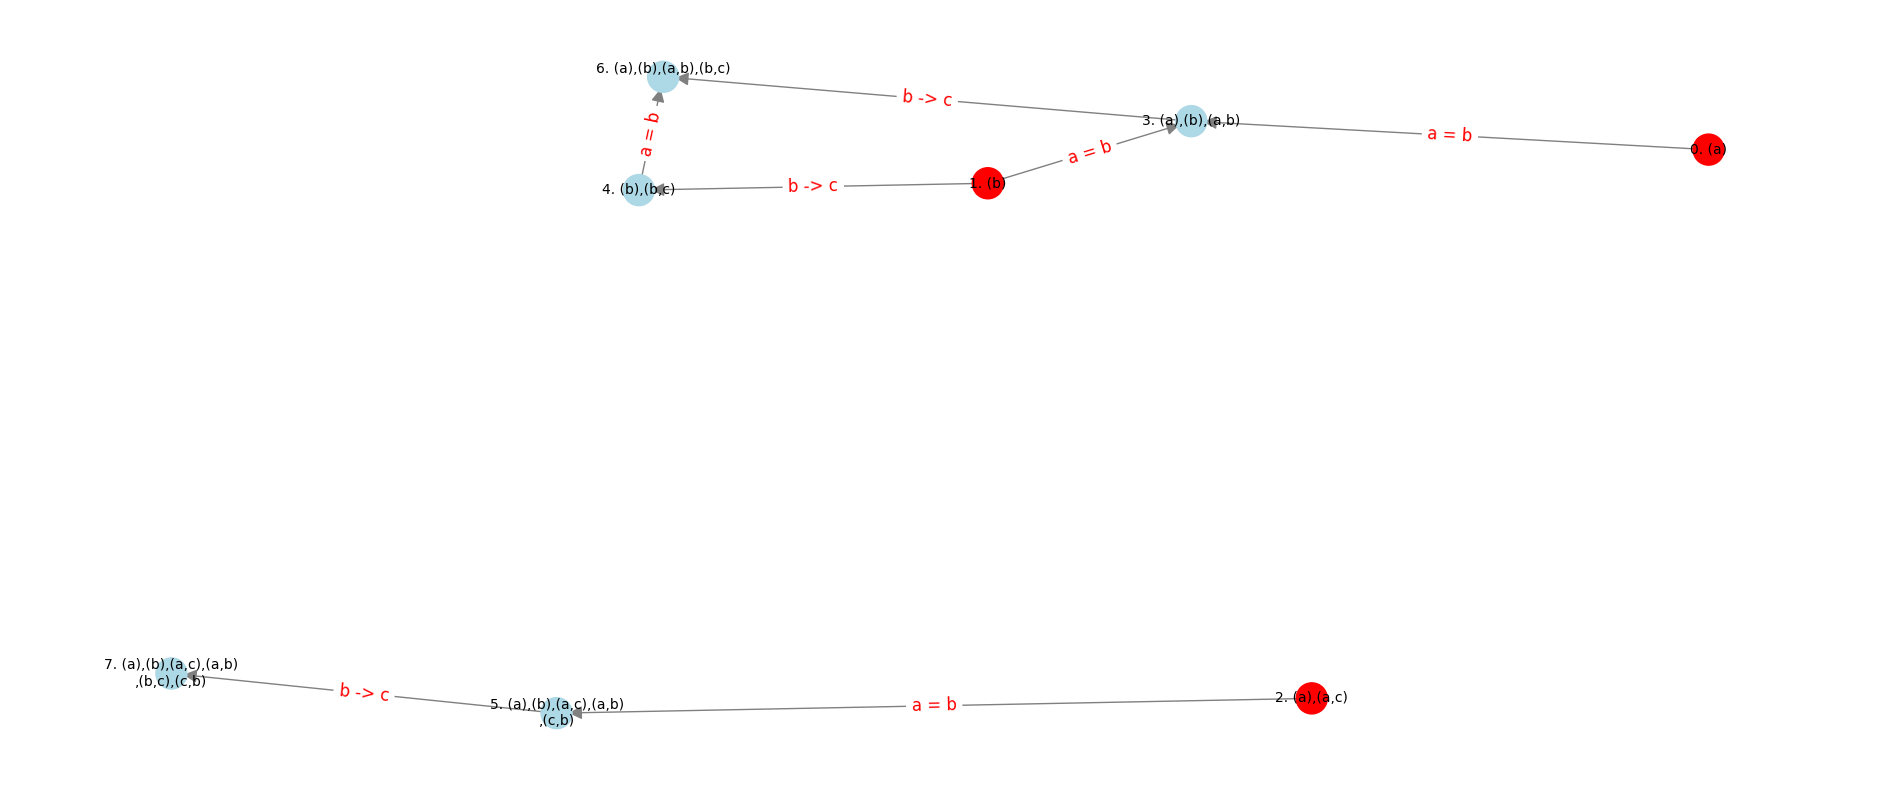

+---+--------+-------+
|   | b -> c | a = b |
+---+--------+-------+
| 0 |   0    |   3   |
| 1 |   4    |   3   |
| 2 |   0    |   5   |
| 3 |   6    |   0   |
| 4 |   0    |   6   |
| 5 |   7    |   0   |
| 6 |   0    |   0   |
| 7 |   0    |   0   |
+---+--------+-------+
{0 -> 3, a = b} {1 -> 3, a = b} {1 -> 4, b -> c} {2 -> 5, a = b} {3 -> 6, b -> c} {4 -> 6, a = b} {5 -> 7, b -> c}


In [20]:
produced = create_orderings(['a', 'b', 'ac'], Ordering.Type.produced)
tested = create_orderings([], Ordering.Type.tested)

fds = [
    FD('b', 'c'), # b -> c
    FD('a', 'b', FD.Type.equiv) # a = b
]

nfsm = NFSM()
nfsm.construct(fds, produced, tested)

after applying fd


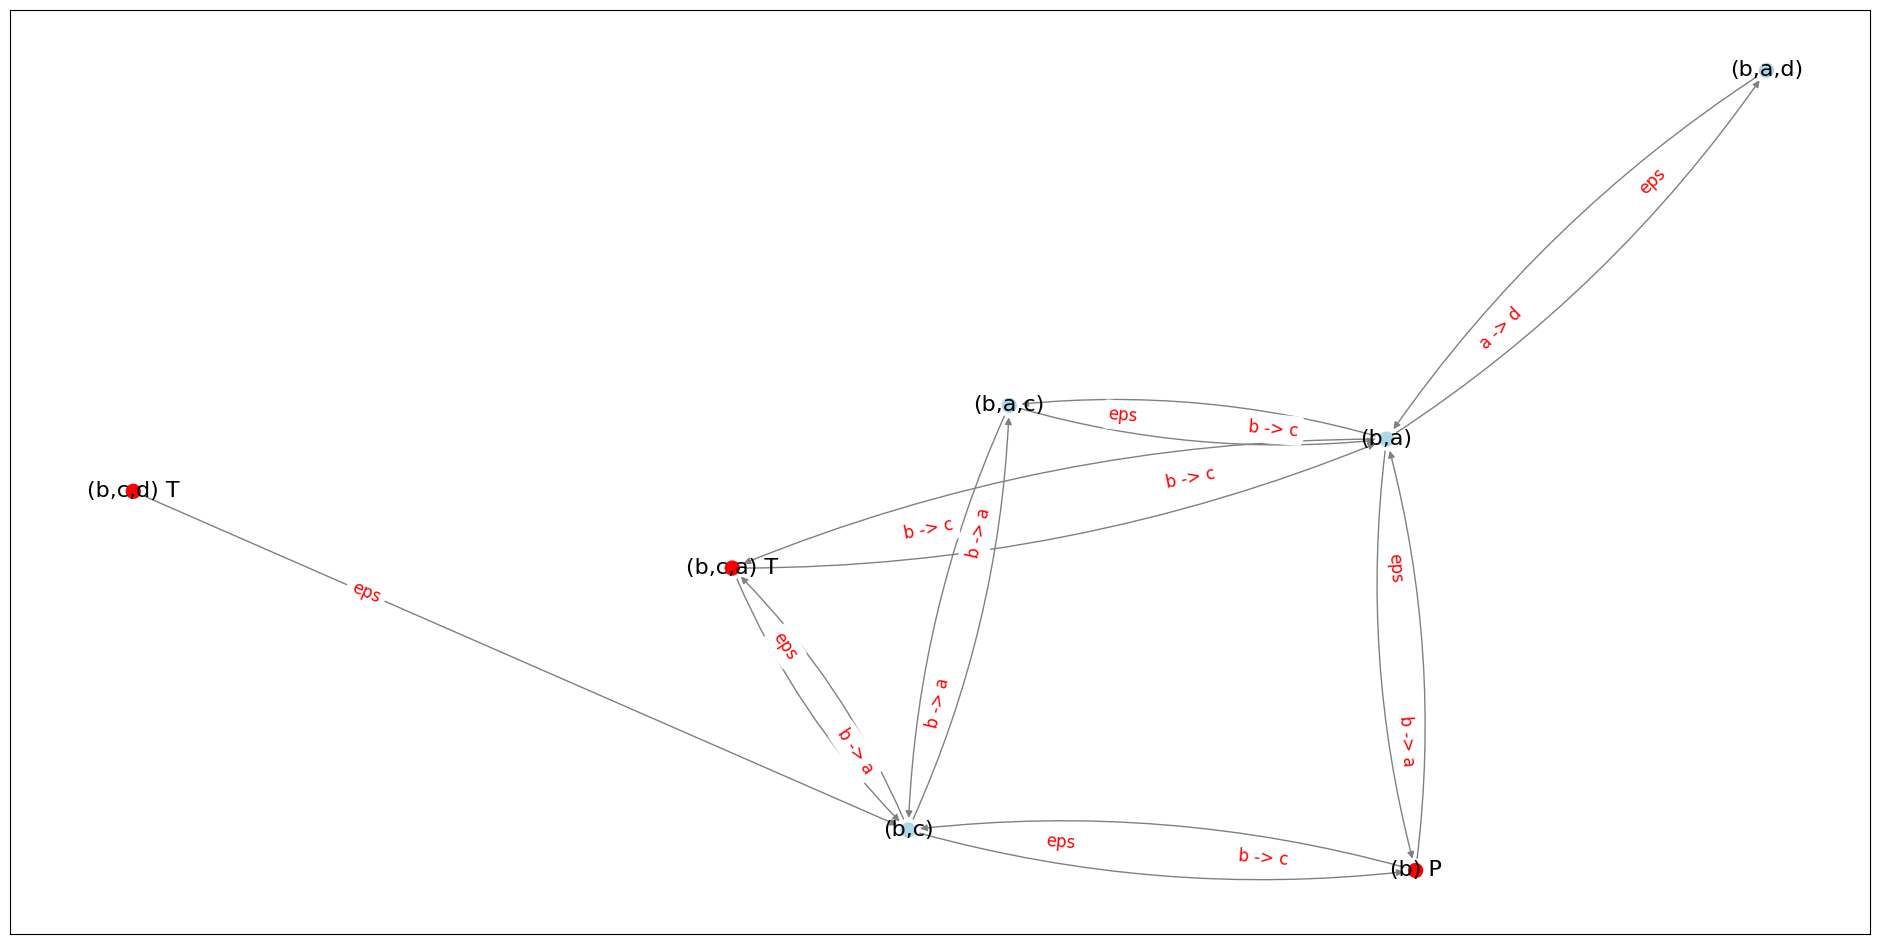

Nodes: [{(b), I}, {(b,c,a), I}, {(b,c,d), I}, {(b,c), A}, {(b,a), A}, {(b,a,c), A}, {(b,a,d), A}]
Edges: 
{(b,c,a) -> (b,c), eps}
{(b,c,d) -> (b,c), eps}
{(b,c) -> (b), eps}
{(b) -> (b,c), b -> c}
{(b) -> (b,a), b -> a}
{(b,a) -> (b), eps}
{(b,c) -> (b,a,c), b -> a}
{(b,a,c) -> (b,c), b -> a}
{(b,c) -> (b,c,a), b -> a}
{(b,a) -> (b,c,a), b -> c}
{(b,c,a) -> (b,a), b -> c}
{(b,a) -> (b,a,c), b -> c}
{(b,a,c) -> (b,a), eps}
{(b,a) -> (b,a,d), a -> d}
{(b,a,d) -> (b,a), eps}

after pruning nodes


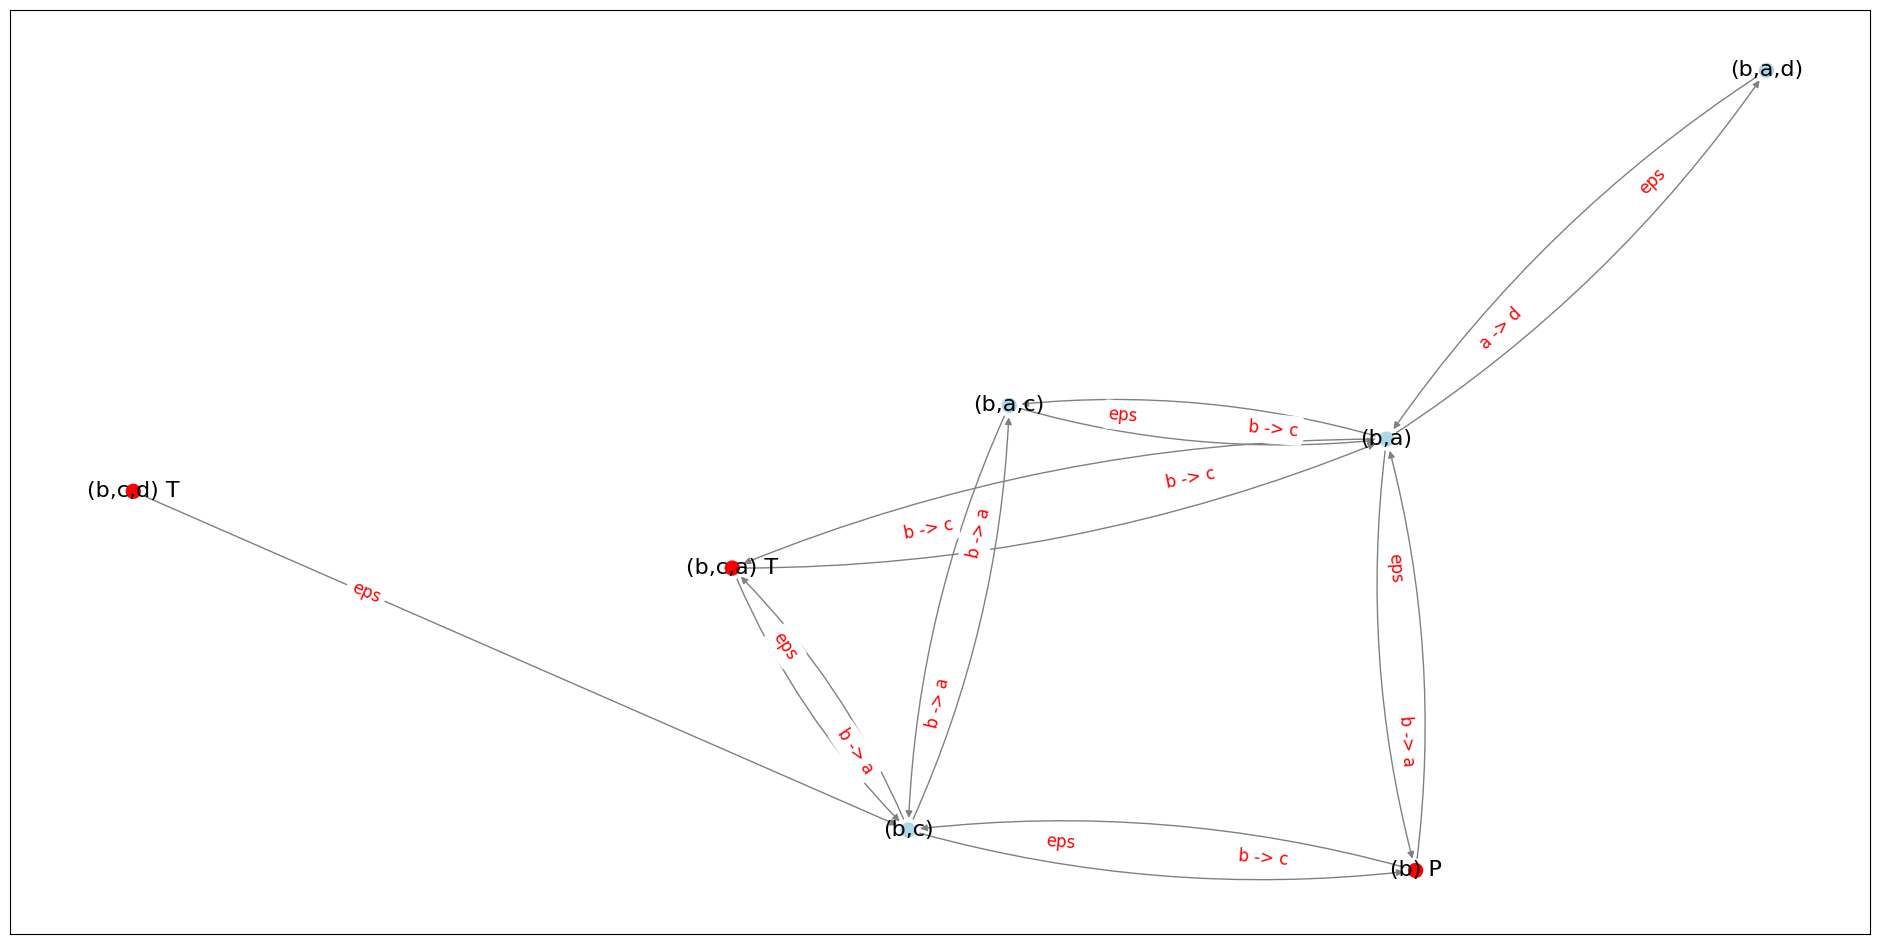

Nodes: [{(b), I}, {(b,c,a), I}, {(b,c,d), I}, {(b,c), A}, {(b,a), A}, {(b,a,c), A}, {(b,a,d), A}]
Edges: 
{(b,c,a) -> (b,c), eps}
{(b,c,d) -> (b,c), eps}
{(b,c) -> (b), eps}
{(b) -> (b,c), b -> c}
{(b) -> (b,a), b -> a}
{(b,a) -> (b), eps}
{(b,c) -> (b,a,c), b -> a}
{(b,a,c) -> (b,c), b -> a}
{(b,c) -> (b,c,a), b -> a}
{(b,a) -> (b,c,a), b -> c}
{(b,c,a) -> (b,a), b -> c}
{(b,a) -> (b,a,c), b -> c}
{(b,a,c) -> (b,a), eps}
{(b,a) -> (b,a,d), a -> d}
{(b,a,d) -> (b,a), eps}



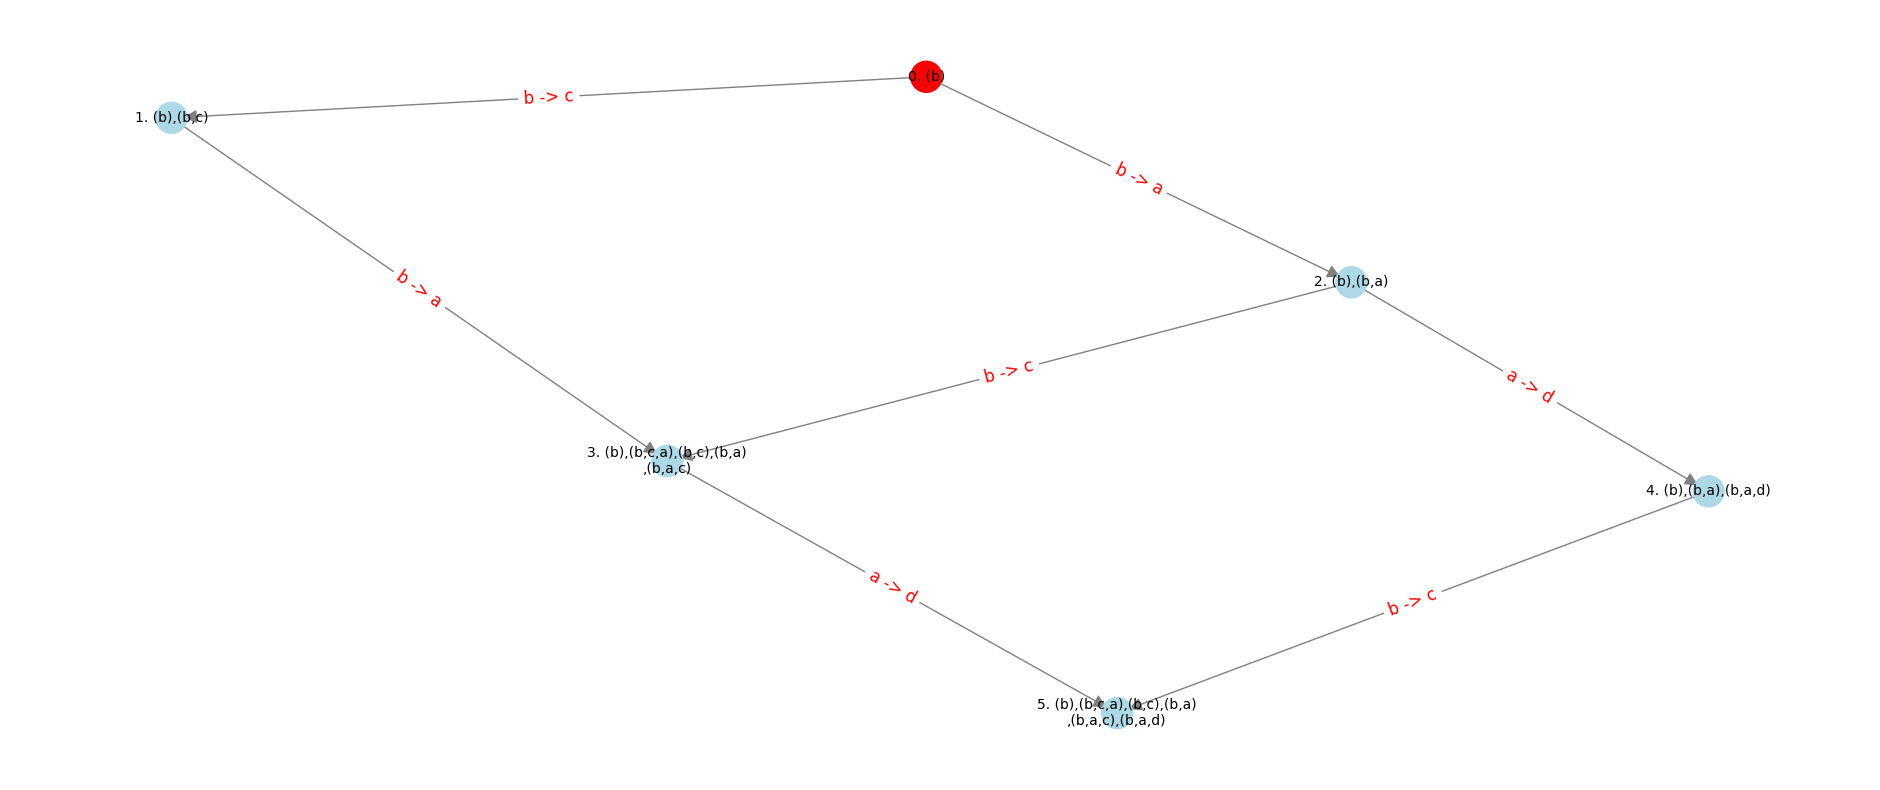

+---+--------+--------+--------+
|   | b -> c | b -> a | a -> d |
+---+--------+--------+--------+
| 0 |   1    |   2    |   0    |
| 1 |   0    |   3    |   0    |
| 2 |   3    |   0    |   4    |
| 3 |   0    |   0    |   5    |
| 4 |   5    |   0    |   0    |
| 5 |   0    |   0    |   0    |
+---+--------+--------+--------+
{0 -> 1, b -> c} {0 -> 2, b -> a} {1 -> 3, b -> a} {2 -> 3, b -> c} {2 -> 4, a -> d} {3 -> 5, a -> d} {4 -> 5, b -> c}


In [21]:
produced = create_orderings(['b'], Ordering.Type.produced)
tested = create_orderings(['bca', 'bcd'], Ordering.Type.tested)

fds = [
    FD('b', 'c'),
    FD('b', 'a'),
    FD('a', 'd'),
]

nfsm = NFSM()
nfsm.construct(fds, produced, tested)